# Classification of Anomalous Diffusion

We'll develop a recurrent neural network to classify different kinds of motions obeying different anomalous diffusion models.

## Load Anomalous Diffusion Models

We load the `datasets_theory()` class from the `andi_datasets` package.

In [1]:
from andi_datasets.datasets_theory import datasets_theory

AnDi = datasets_theory()
model_names = AnDi.avail_models_name
model_number = len(model_names)

print(f"{model_number} anomalous diffusion models: {model_names}")

5 anomalous diffusion models: ['attm', 'ctrw', 'fbm', 'lw', 'sbm']


## Simulate Trajectories

We now proceed to simulate the necessary trajectories for the dataset. This might take a few minutes. This will generate `N = 4000` trajectories for each anomalous diffusion model, each with random anomalous diffusion coefficients. Each trajectory contains `T = 100` time steps.

The dataset contains rows with lenght `2 + D * T`, with the following structure:
* First column: model label 
* Second column: value of the anomalous exponent
* Following columns: trajectories

In [2]:
from numpy import concatenate as cat
from numpy.random import rand

T = 100  # Time steps.
N = 4000  # Trajectories per model.
D = 2  # Dimensionality.

dataset = cat(
    (
        AnDi.create_dataset(  # CARLO: should we use a create_noisy_diffusion_dataset?
            T=T + 1,
            N_models=1,
            exponents=(rand(N) + 0.2) / 1.2,
            models=[0, 1],  # attm, ctrw
            dimension=D,
        ),
        AnDi.create_dataset(  # CARLO: should we use a create_noisy_diffusion_dataset?
            T=T + 1,
            N_models=1,
            exponents=(rand(N) * 1.8) + 0.2,
            models=[2, 4],  # fbm, sbm
            dimension=D,
        ),
        AnDi.create_dataset(  # CARLO: should we use a create_noisy_diffusion_dataset?
            T=T + 1,
            N_models=1,
            exponents=rand(N) + 1,
            models=3,  # lw
            dimension=D,
        ),
    ),
    axis=0,
)

print(f"{dataset.shape}")

(20000, 204)


## adding localization noise

In [3]:
dataset = AnDi.create_noisy_diffusion_dataset(
    dataset, diffusion_coefficients=1.0, T=T + 1, dimension=2
)
dataset = AnDi.create_noisy_localization_dataset(
    dataset, T=T + 1, dimension=2, sigma=0.1
)
dataset = AnDi.create_noisy_diffusion_dataset(dataset, T=T + 1, dimension=2)

We now shuffle the dataset and extract the model numbers, anomalous exponents, and the x and y components of the trajectories.

In [4]:
from numpy.random import shuffle

shuffle(dataset)

models = dataset[:, 0]
exponents = dataset[:, 1]
trajectories = dataset[:, 2:].reshape(-1, T + 1, D, order="F")

## Visualize Trajectories
We display trajectories corresponding to different models with a similar exponent.

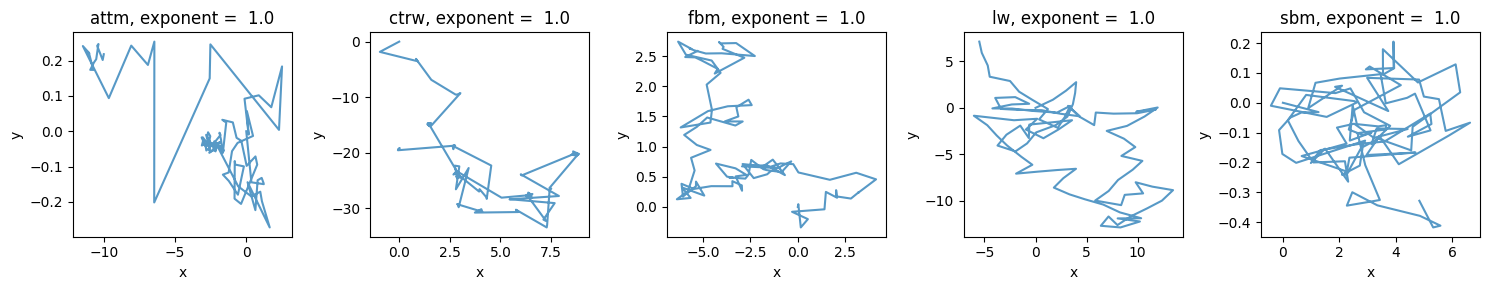

In [5]:
import matplotlib.pyplot as plt
from numpy import where

fig, axs = plt.subplots(1, model_number, figsize=((15, 3)), tight_layout=True)

for m, ax in zip(range(model_number), axs):
    idx = where((models == m) & (exponents > 0.95) & (exponents < 1.05))[0][0]
    ax.plot(trajectories[idx, :, 0], trajectories[idx, :, 1], alpha=0.75)
    ax.set_title(f"{model_names[m]}, exponent =  {exponents[idx]:.1f}")
    plt.setp(ax, xlabel="x", ylabel="y")

## Prepare Data

We now prepare the data to be used by for the neural network training. We will use the trajectory displacements, i.e. the difference between positions at consecutive frames, standardized to have mean equal to zero and standard deviation equal to unit. 
We reshape the displacement time-series according to a time `window` to be used in the recurrent neural network training.

In [6]:
from numpy import diff

window = 2
n_timesteps = int(T / window)
n_features = D * window

displ = diff(trajectories, axis=1)
displ -= displ.mean(axis=1, keepdims=True)
displ /= displ.std(axis=1, keepdims=True)

inputs = displ.reshape(displ.shape[0], n_timesteps, n_features)

We then one-hot encode the targets. For this, we first implement two functions, that we add to `fnc_andi.py` ...

```python
```

```python
```

... and then use them to one-hot encode the anomalous diffusion models.

In [7]:
from numpy import argmax, zeros


def digits_to_one_hot(digits, n_classes):
    """Convert an array of integer digits to a 2D one-hot encoded matrix."""

    one_hot_labels = zeros((digits.shape[0], n_classes))
    for idx, digit in enumerate(digits):
        one_hot_labels[idx, digit] = 1
    return one_hot_labels


def one_hot_to_digit(one_hot_labels):
    """Convert a 2D one-hot encoded matrix to a 1D array of integer digits."""

    return argmax(one_hot_labels, axis=-1)

In [8]:
# from fnc_andi import digits_to_one_hot

targets = digits_to_one_hot(models.astype(int), model_number)

We then convert them into PyTorch tensors ...

In [9]:
import torch

inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

... split them into train, validation, and test datasets ...

In [10]:
from torch.utils.data import random_split, TensorDataset

[train_ds, val_ds, test_ds] = random_split(
    TensorDataset(inputs, targets), [0.6, 0.2, 0.2]
)

... and create the necessary data loaders.

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

## Use Simple RNN

We start by using a simple RNN.

In [47]:
import deeplay as dl

rnn = dl.RecurrentNeuralNetwork(
    in_features=n_features,
    hidden_features=[100],
    out_features=model_number,
)
rnn.blocks.dropout.configure(p=0.2)


model_rnn = dl.Classifier(
    model=rnn, loss=torch.nn.CrossEntropyLoss(), optimizer=dl.Adam(lr=0.001)
)
model_rnn.create()
print(model_rnn)

Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RecurrentNeuralNetwork(
    (blocks): LayerList(
      (0): LayerActivationNormalizationDropout(
        (layer): Layer[RNN](input_size=4, hidden_size=100)
        (activation): Layer[Identity](num_features=4)
        (normalization): Layer[Identity](num_features=4)
        (dropout): Layer[RecurrentDropout](p=0.2)
      )
      (1): LayerActivationNormalizationDropout(
        (layer): Layer[RNN](input_size=100, hidden_size=5)
        (activation): Layer[Identity](num_features=4)
        (normalization): Layer[Identity](num_features=4)
        (dropout): Layer[RecurrentDropout](p=0.2)
      )
    )
  )
  (optimizer): Adam[Adam](lr=0.001, params=<generator object Module.parameters at 0x15bb8c6d0>)
)


We now proceed to train the neural network ...

In [48]:
trainer_rnn = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_rnn.fit(model_rnn, train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MisconfigurationException: Unknown configuration for model optimizers. Output from `model.configure_optimizers()` should be one of:
 * `Optimizer`
 * [`Optimizer`]
 * ([`Optimizer`], [`LRScheduler`])
 * {"optimizer": `Optimizer`, (optional) "lr_scheduler": `LRScheduler`}


... and test it on the test dataset ...

In [46]:
preds_rnn = trainer_rnn.predict(model_rnn, test_loader)
preds_rnn = torch.cat(preds_rnn, dim=0).clone().detach()

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Unexpected call to forward. Did you forget to `create` or `build`?

... and evaluate its performance. For this, we write the `get_groundtruths()` and `accuracy()` functions, save them into `fnc_andi.py` ...

```python
```

```python
```

... and use it to calculate the accuracy.

In [ ]:
import torch


def get_groundtruths(loader):
    """Returns the groundtruth targets."""

    groundtruths = []
    for _, target in loader:
        groundtruths.append(target)

    groundtruths = torch.cat(groundtruths, dim=0)
    groundtruths = torch.tensor(groundtruths)

    return groundtruths


def accuracy(predictions, groundtruths):
    """Calculate the accuracy."""

    predictions = one_hot_to_digit(predictions)
    groundtruths = one_hot_to_digit(groundtruths)
    correct = sum(predictions == groundtruths)
    total = predictions.shape[0]
    return correct / total

In [ ]:
# from fnc_andi import accuracy, get_groundtruths

groundtruths = get_groundtruths(test_loader)

accuracy_rnn = accuracy(preds_rnn, groundtruths)
print(f"Accuracy Simple RNN: {accuracy_rnn}")

We then plot the confusion matrix.

```python
```

In [ ]:
import matplotlib.pyplot as plt
from numpy import zeros
from seaborn import heatmap, cubehelix_palette


def plot_confusion_matrix(predictions, groundtruths):
    """Calculate and plot confusion matrix."""

    confusion_matrix = zeros((5, 5))
    predictions = one_hot_to_digit(predictions)
    groundtruths = one_hot_to_digit(groundtruths)
    for pred_idx, gt_idx in zip(predictions, groundtruths):
        confusion_matrix[pred_idx, gt_idx] += 1
    confusion_matrix *= 100 / confusion_matrix.sum(axis=0, keepdims=1)

    plt.figure(figsize=(10, 8))
    heatmap(
        confusion_matrix,
        annot=True,
        fmt=".1f",
        square=True,
        cmap=cubehelix_palette(light=0.95, as_cmap=True),
        vmax=100,
    )
    plt.xlabel("Predicted model", fontsize=15)
    xlocs, _ = plt.xticks()
    plt.xticks(ticks=xlocs, labels=model_names)
    plt.ylabel("Ground truth model", fontsize=15)
    ylocs, _ = plt.yticks()
    plt.yticks(ticks=ylocs, labels=model_names)
    plt.show()

In [ ]:
# from fnc_andi import plot_confusion_matrix

plot_confusion_matrix(preds_rnn, groundtruths)

## Use GRU

In [ ]:
rnn.blocks[0].layer.configure(torch.nn.GRU)
model_gru = dl.Classifier(
    rnn, loss=torch.nn.CrossEntropyLoss(), optimizer=dl.Adam(lr=0.01)
).create()

print(model_gru)

trainer_gru = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_gru.fit(model_gru, train_loader, val_dataloaders=val_loader)

preds_gru = trainer_rnn.predict(model_gru, test_loader)
preds_gru = torch.cat(preds_gru, dim=0).clone().detach()

accuracy_gru = accuracy(preds_gru, groundtruths)
print(f"Accuracy GRU: {accuracy_gru}")

plot_confusion_matrix(preds_gru, groundtruths)

## Use LSTM

In [ ]:
rnn.blocks[0].layer.configure(torch.nn.LSTM)
rnn.blocks[0].layer.configure(
    hidden_size=50
)  # To bring the total parameter count more in-line with a simple RNN.
rnn.blocks[1].layer.configure(in_features=50)
model_lstm = dl.Classifier(
    rnn, loss=torch.nn.CrossEntropyLoss(), optimizer=dl.Adam(lr=0.01)
).create()

print(model_lstm)

trainer_lstm = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_lstm.fit(model_lstm, train_loader, val_dataloaders=val_loader)

preds_lstm = trainer_rnn.predict(model_lstm, test_loader)
preds_lstm = torch.cat(preds_lstm, dim=0).clone().detach()

accuracy_lstm = accuracy(preds_lstm, groundtruths)
print(f"Accuracy LSTM: {accuracy_lstm}")

plot_confusion_matrix(preds_lstm, groundtruths)

## Use Bidirectional LSTM

In [ ]:
rnn = dl.RNN(
    n_features,
    hidden_features=[50],
    out_features=model_number,
    dropout=0.2,
    rnn_type="LSTM",
    bidirectional=True,
)
rnn.blocks.dropout.configure(
    p=0.2
)  # HENRIK, BENJAMIN: I need to add this to see the dropout in the printout
model_bi = dl.Classifier(
    rnn, loss=torch.nn.CrossEntropyLoss(), optimizer=dl.Adam(lr=0.01)
).create()

print(model_bi)

trainer_bi = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_bi.fit(model_bi, train_loader, val_dataloaders=val_loader)

preds_bi = trainer_rnn.predict(model_bi, test_loader)
preds_bi = torch.cat(preds_bi, dim=0).clone().detach()

accuracy_bi = accuracy(preds_bi, groundtruths)
print(f"Accuracy Bidirectional LSTM: {accuracy_bi}")

plot_confusion_matrix(preds_bi, groundtruths)

## Adding layers to LSTM (overfitting)

In [ ]:
rnn = dl.RecurrentNeuralNetwork(  # HENRIK, BENJAMIN: why not RNN like above?
    n_features,
    hidden_features=[100],
    out_features=30,
)
rnn.blocks.dropout.configure(
    p=0.2
)  # HENRIK, BENJAMIN: I need to add this to see the dropout in the printout
rnn.blocks.layer.configure(
    torch.nn.LSTM
)  # HENRIK, BENJAMIN: this shouldn't be needed because it's above, right?

dense_top = dl.MultiLayerPerceptron(
    in_features=None,
    hidden_features=[15],
    out_features=model_number,
)
dense_top.blocks.dropout.configure(
    p=0.2
)  # HENRIK, BENJAMIN: can this be put as an argument?

dense_rnn = dl.Sequential(rnn, dense_top)
model_overfit = dl.Classifier(
    dense_rnn,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=dl.Adam(lr=0.01),
).create()

print(model_overfit)

trainer_overfit = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_overfit.fit(model_overfit, train_loader, val_dataloaders=val_loader)

preds_overfit = trainer_rnn.predict(model_overfit, test_loader)
preds_overfit = torch.cat(preds_overfit, dim=0).clone().detach()

accuracy_overfit = accuracy(preds_overfit, groundtruths)
print(f"Accuracy Bidirectional LSTM: {accuracy_overfit}")

plot_confusion_matrix(preds_overfit, groundtruths)